*   MLP & Deep Learning
*   Classification & Regression
*   ReLU & Softmax Activations
*   Loss Functions & Backpropagation
*   CNN, Image Classificaiton & Object Detection
*   Frameworks & PyTorch:
 *   A NumPy replacement that uses the power of GPUs
 *   A flexible and fast deep learning research platform



# Autograds in PyTorch
Torch module for automatically calculating gradients of tensors

In [10]:
import torch

x = torch.rand(5, 3) # Tensors
y = torch.rand(5, 3)
print(x + y) # Operations
print(torch.add(x, y)) # Operations

tensor([[0.6316, 1.0555, 1.7354],
        [0.9838, 1.2531, 0.8076],
        [0.8046, 0.8538, 1.5432],
        [0.7062, 1.8676, 1.4439],
        [0.8270, 1.2799, 1.3503]])
tensor([[0.6316, 1.0555, 1.7354],
        [0.9838, 1.2531, 0.8076],
        [0.8046, 0.8538, 1.5432],
        [0.7062, 1.8676, 1.4439],
        [0.8270, 1.2799, 1.3503]])


In [11]:
w = torch.randn(2,2, requires_grad=True) # Like wights in our NN case
w_square = w**2
L = w_square.mean() # L=(w^2)/4, like loss in our NN case
print(w)
print(w_square)
print(L)

tensor([[-0.9909, -0.3153],
        [-0.1005,  0.8001]], requires_grad=True)
tensor([[0.9819, 0.0994],
        [0.0101, 0.6402]], grad_fn=<PowBackward0>)
tensor(0.4329, grad_fn=<MeanBackward0>)


In [12]:
print(w_square.grad_fn) # grad_fn shows the function that generated this variable

print(w.grad) # currently empty, d?/dw
L.backward() # calculate the gradient for dL/dw (mean_power function)
print(w.grad)

# L=(w^2)/4, so dL/dw = 2*w/4 = w/2
print(w/2)

None
tensor([[-0.4954, -0.1576],
        [-0.0503,  0.4001]])
tensor([[-0.4954, -0.1576],
        [-0.0503,  0.4001]], grad_fn=<DivBackward0>)


# Training in PyTorch

## Reading Data

In [16]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# Define a transform to normalize the data, download it, and create a loader (generator)
#transform = transforms.Compose([transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                               ])
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.0], [0.5]),  # Mean & Standard Deviation
                               ])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw




Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


KeyboardInterrupt: ignored

## Creating Model & Forward Pass

In [ ]:
torch.cuda.is_available()

# Build a feed-forward network
# image size = 28X28X1 = 784 pixels
model = nn.Sequential(nn.Linear(784, 128), # number neruons in first layer = 128 
                      nn.ReLU(),
                      nn.Linear(128, 64), # number neruons in second layer = 64
                      nn.ReLU(),
                      nn.Linear(64, 10), # number neruons in second layer = 10
                      nn.LogSoftmax(dim=1))

#----------------------------------|--------------------|--------------------|------------------------

# net_L1,N1   = w1,1   * p1        + w1,2   * p2        +         ...        + w1,784   * p784       
# net_L1,N2   = w2,1   * p1        + w2,2   * p2        +         ...        + w2,784   * p784       
# net_L1,N128 = w128,1 * p1        + w128,2 * p2        +         ...        + w128,784 * p784       

#----------------------------------|--------------------|--------------------|------------------------

# net_L2,N1   = w1,1   * net_L1,N1 + w1,2   * net_L1,N2 +         ...        + w1,128   * net_L1,N128
# net_L2,N2   = w2,1   * net_L1,N1 + w2,2   * net_L1,N2 +         ...        + w2,128   * net_L1,N128
# net_L2,N64  = w64,1  * net_L1,N1 + w64,2  * net_L1,N2 +         ...        + w64,128  * net_L1,N128

#----------------------------------|--------------------|--------------------|------------------------

# net_L3,N1   = w1,1   * net_L2,N1 + w1,2   * net_L2,N2 +         ...        + w1,64    * net_L2,N64
# net_L3,N2   = w2,1   * net_L2,N1 + w2,2   * net_L2,N2 +         ...        + w2,64    * net_L2,N64
# net_L3,N10  = w10,1  * net_L2,N1 + w10,2  * net_L2,N2 +         ...        + w10,64   * net_L2,N64

#----------------------------------|--------------------|--------------------|------------------------

# Define the loss (NLLLoss to LogSoftmax = CrossEntropyLoss to Softmax but its practical implementation is more efficient)
loss_function = nn.NLLLoss() # recieves LogSoftmax and labels

# Get our data
images, labels = next(iter(trainloader)) # returns the next item from the iterator to the RAM
images = images.view(images.shape[0], -1) # Flatten images to be batch_size X feature vector (not image)

# Forward pass, get our log-probabilities
logps = model(images)
loss = loss_function(logps, labels) # Calculate the loss with the logps and the labels
print(loss)

# Print network output for the first image and calculate the sum
import numpy as np
print(torch.exp(logps[0]))
print(torch.sum(torch.exp(logps[0])))

## Calculate Gradients

In [ ]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Read a batch of data
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1) # From shape torch.Size([64, 1, 28, 28]) to torch.Size([64, 784])

# Forward pass and calcuate loss
loss_function = nn.NLLLoss()
logps = model(images) 
loss = loss_function(logps, labels)

print('Gradient before backward pass: \n', model[0].weight.grad) # d?/d(model[0].weight)

loss.backward() # loss is function of model[0].weights, model[1].weights, and model[2].weights

print('Gradient after backward pass: \n', model[0].weight.grad) # d(loss)/d(model[0].weight) --> sparse in MNIST case of gray scale images
print('Gradient after backward pass: \n', model[0].weight.grad.nonzero()) # returns indices of non zero elements

## Backpropagation Step

In [ ]:
# Training the network
from torch import optim
optimizer = optim.SGD(model.parameters(), lr=0.1) # Requires the parameters to optimize and a learning rate

# Read a batch of data
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1) # From shape torch.Size([64, 1, 28, 28]) to torch.Size([64, 784])

# Clear the gradients because they are accumulated in PyTorch
optimizer.zero_grad()

# Forward pass and then calucate the gradients (gradients are requirment for for backward pass)
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print('First layer weights gradient: ', model[0].weight.grad) # sparse in MNIST case of gray scale images

# Take an update step and few the view weights
print('Initial weights: ', model[0].weight)
initial_weights = model[0].weight.detach().numpy().copy() # detach if variable has requires_grad=True
optimizer.step() # The gradients are computed by the loss.backward() call
print('Updated weights: ', model[0].weight)

new_weights = model[0].weight
index = new_weights.grad.nonzero()[0] # First changed weight
print("-----------------------------")
print("The first weight in the first layer was " + str(initial_weights[0,0]))
print("The first weight in the first layer became " + str(new_weights[0,0].detach().numpy()))
# Most probably not changed due to zero gradient due to MNIST images black edges
print("-----------------------------")
print("The first changed weight in the first layer was " + str(initial_weights[index[0], index[1]]))
print("The gradient of that weight = " + str(model[0].weight.grad[index[0], index[1]]))
print("The first changed weight in the first layer became " + str(new_weights[index[0], index[1]].detach().numpy())) # This should be equal to previous value - lr * gradient calculated in previous line

## Putting everything together

In [ ]:
# Training on data
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1) # Flatten MNIST images into a 784 long vector
    
        # Training pass
        optimizer.zero_grad()
        output = model.forward(images)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
       
        running_loss += loss.item() # item() converts the value into a plain python number living in the CPU RAM
    else: # At the epoch ends
        print("Average Batch training loss this epoch: " + str({running_loss/len(trainloader)})) # Avergae over batches

## Test the model on samples

Run it more than one time to check!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

images, labels = next(iter(trainloader))
img = images[0].view(1, 784)
with torch.no_grad(): # Turn off gradients to speed up this part
    logps = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = torch.exp(logps).squeeze()
plt.imshow(images[0].permute(1,2,0).squeeze()) # from torch.Size([1, 28, 28]) to torch.Size([28, 28, 1]) to torch.Size([28, 28])
print(ps)
print(sum(ps))

prediction_label = np.argmax(ps).item()
conf = int(max(ps).item()*100)
print("Our trained model predicts that image to be: " + str(prediction_label) + ", with a confidence of " + str(conf) + "%")

# Image Classification

The problem wth the above network is that they lose spatial orientation.

<img src=https://raw.githubusercontent.com/heshameraqi/Image-Classifiaciton-Object-Detection-with-PyTorch-Workshop/main/imgs/CNN_view.png width="500">

(Image adapted from: learnopencv.com, 11/2020)

## Use a pre-trained model

In [1]:
import torch
from torchvision import models
from torchvision import transforms

dir(models)
model = models.vgg16(pretrained=True)
print(model)

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Classify an image

torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])


[('Labrador retriever', 58.634315490722656),
 ('golden retriever', 6.773661136627197),
 ('kelpie', 3.932812452316284),
 ('dingo, warrigal, warragal, Canis dingo', 3.2133336067199707),
 ('Chesapeake Bay retriever', 2.846714496612549)]

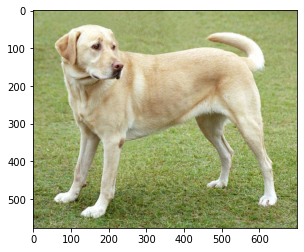

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

!wget -q -nc https://raw.githubusercontent.com/heshameraqi/Image-Classifiaciton-Object-Detection-with-PyTorch-Workshop/main/imgs/dog.jpg
img = Image.open("dog.jpg") # A yellow labrador (Image source: Wikipedia)
plt.imshow(img)

img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)
print(batch_t.shape)

model.eval() # Out our model in evaluation mode
out = model(batch_t)
print(out.shape)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

!wget -q -nc https://raw.githubusercontent.com/heshameraqi/Image-Classifiaciton-Object-Detection-with-PyTorch-Workshop/main/data/imagenet1000.names
classes_dict = eval(open('./imagenet1000.names').read())
_, indices = torch.sort(out, descending=True)
[(classes_dict[i.item()], percentage[i].item()) for i in indices[0][:5]] # Print top 5 classifications

# R-CNN

## Run the detector

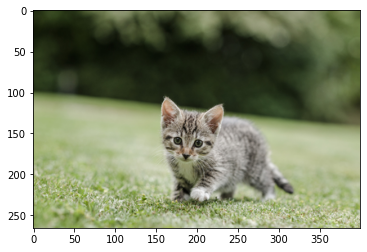

In [2]:
import torch
from torchvision import models
from torchvision import transforms
from tqdm.auto import tqdm
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 50 # Depends on the GPU memory, the bigger the faster :)

# Load model and transform
model = models.vgg16(pretrained=True)
model.eval() # Use the model in evaluation mode
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
n_rows, n_cols = 256, 256 # Input size of the used model

# Read input image and resize it
size = 400, 400 # resize the input image
!wget -q -nc https://raw.githubusercontent.com/heshameraqi/Image-Classifiaciton-Object-Detection-with-PyTorch-Workshop/main/imgs/cat.jpg
img = Image.open("cat.jpg") # A yellow labrador (Image source: Wikipedia)
img.thumbnail(size, Image.ANTIALIAS)
plt.imshow(img)

# Configurations. Selected to suite the workshop limited time, normally they should provide much more boxes (exponential growth)
window_min_size = 100  # object minimum dimension
window_max_size = 200 # object minimum dimension
window_size_step = 100
window_pos_stride = 50

# Crop images
images_to_classify = []
location_size = []
for s_h in range(window_min_size, window_max_size, window_size_step):
  for s_w in range(window_min_size, window_max_size, window_size_step):
    for h in range(0, img.size[0], window_pos_stride):
      for w in range(0, img.size[1], window_pos_stride):
          # Crop image
          height_to = np.min([h+s_h, n_rows])
          width_to = np.min([w+s_w, n_cols])
          # [h,w,height_to,width_to] = [110,50,290,130]  # For debugging
          box = (w, h, w+width_to, h+height_to)
          cropped_img = img.crop(box)

          # Preprocess image
          location_size.append([h,w,height_to,width_to])
          images_to_classify.append(transform(cropped_img))

# Classify cropped images as batches
confidences = []
winner_classes_idx = []
for i in tqdm(range(0, len(images_to_classify), batch_size)):
  preds = model(torch.stack(images_to_classify[i:i+batch_size]))
  for c in preds.detach().numpy():
    confidences.append(np.max(c))
    winner_classes_idx.append(np.argmax(c))

## Visualize Detected Objects

<Figure size 432x288 with 0 Axes>

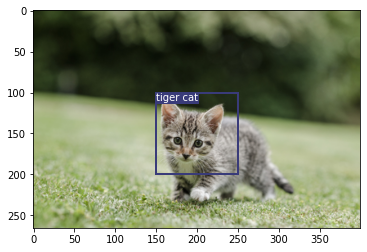

In [3]:
import matplotlib.patches as patches
import random

# Number of predictions needed
predictions = 1

# Read classes names
!wget -q -nc https://raw.githubusercontent.com/heshameraqi/Image-Classifiaciton-Object-Detection-with-PyTorch-Workshop/main/data/imagenet1000.names
classes_dict = eval(open('./imagenet1000.names').read())

# Sort predictions
sort_idx = (-np.array(confidences)).argsort()
confidences = [confidences[i] for i in sort_idx]
location_size = [location_size[i] for i in sort_idx]
winner_classes_idx = [winner_classes_idx[i] for i in sort_idx]

# Bounding-box colors (at most visualize 20 objects)
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img)
nbrObjects = min([len(confidences), predictions])
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, nbrObjects)]
bbox_colors = random.sample(colors, nbrObjects)
for i in range(nbrObjects):
  if confidences[i] <= 0.85:
    break
  [h, w, height_to, width_to] = location_size[i]
  box_w = width_to - w
  box_h = height_to - h
  # Create and add the bbox to the plot
  ax.add_patch(patches.Rectangle((w, h), box_w, box_h, linewidth=2, edgecolor=bbox_colors[i], facecolor="none"))
  # Add label
  plt.text(w, h, s=classes_dict[winner_classes_idx[i]], color="white", verticalalignment="top", bbox={"color": bbox_colors[i], "pad": 0})

plt.show()

# Fast R-CNN

## Imports, read model, read image, and install Selective Search

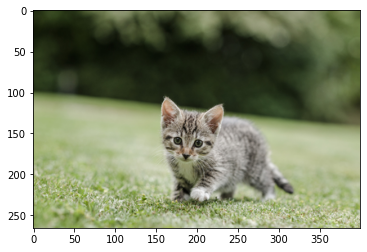

In [1]:
!pip install selectivesearch
import selectivesearch

from PIL import Image
import torch
from torchvision import models
from torchvision import transforms
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.auto import tqdm
import random

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 50

# Load model and transform
model = models.vgg16(pretrained=True)
model.eval() # Use the model in evaluation mode
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Read and resize image
size = 400, 400 # resize the input image
!wget -q -nc https://raw.githubusercontent.com/heshameraqi/Image-Classifiaciton-Object-Detection-with-PyTorch-Workshop/main/imgs/cat.jpg
img = Image.open("cat.jpg") # A yellow labrador (Image source: Wikipedia)
img.thumbnail(size, Image.ANTIALIAS)
plt.imshow(img)

# Read classes names
!wget -q -nc https://raw.githubusercontent.com/heshameraqi/Image-Classifiaciton-Object-Detection-with-PyTorch-Workshop/main/data/imagenet1000.names
classes_dict = eval(open('./imagenet1000.names').read())

## Run the detector

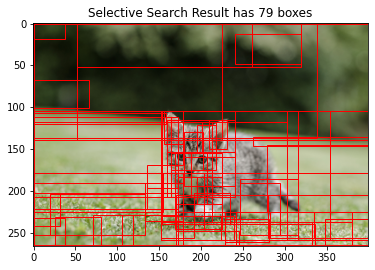

In [6]:
img_lbl, regions = selectivesearch.selective_search(np.asarray(img), scale=200, sigma=0.4, min_size=200)
candidates = set()
for r in regions:
    if r['rect'] in candidates: # excluding same rectangle (with different segments)
        continue
    if r['size'] < 20*20: # excluding regions smaller than X pixels
        continue
    ''''x, y, w, h = r['rect'] # excluding regions with extreme aspect ratios
    if h==0 or w==0 or w / h > 3 or h / w > 3:
        continue'''
    candidates.add(r['rect'])
candidates = list(candidates)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(img)
for x, y, w, h in candidates:
    rect = patches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
plt.title('Selective Search Result has ' + str(len(candidates)) + ' boxes')
plt.show()

images_to_classify = []
for x, y, w, h in candidates: # Candidates: bottom, left, width, height
    box = (x, y, x+w, y+h)
    cropped_img = img.crop(box)
    images_to_classify.append(transform(cropped_img))

confidences = []
winner_classes_idx = []
for i in tqdm(range(0, len(images_to_classify), batch_size)):
  preds = model(torch.stack(images_to_classify[i:i+batch_size]))
  for c in preds.detach().numpy():
    confidences.append(np.max(c))
    winner_classes_idx.append(np.argmax(c))

## Visualize detected objects

<Figure size 432x288 with 0 Axes>

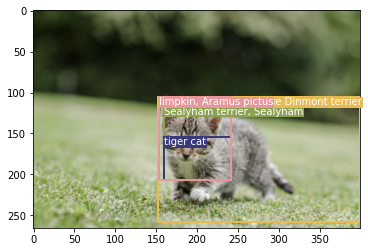

In [8]:
# Predictions needed
predictions = 5

# Sort predictions
sort_idx = (-np.array(confidences)).argsort()
confidences = [confidences[i] for i in sort_idx]
candidates = [candidates[i] for i in sort_idx]

plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img)

# Bounding-box colors (at most visualize 20 objects)
nbrObjects = min([len(confidences), predictions])
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, nbrObjects)]
bbox_colors = random.sample(colors, nbrObjects)
for i in range(nbrObjects):
  #if confidences[i] <= 0.85:
  #  break
  
  [x, y, w, h] = candidates[i]
  # Create and add the bbox to the plot
  ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=bbox_colors[i], facecolor="none"))
  # Add label
  plt.text(x, y, s=classes_dict[winner_classes_idx[i]],
      color="white", verticalalignment="top", bbox={"color": bbox_colors[i], "pad": 0},)
  
plt.show()

# Single-shot Object Detection

## Install PyTorch-YOLOv3 Python requirements

In [9]:
%cd object-detection-dl-workshop/PyTorch-YOLOv3
!pip3 install -r requirements.txt

[Errno 2] No such file or directory: 'object-detection-dl-workshop/PyTorch-YOLOv3'
/content
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


## Imports

In [ ]:
from __future__ import division

from models_yolo import *
from utils.utils import *
from utils.datasets import *

import os
import sys
import time
import datetime
import argparse

from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import lycon  # A minimal and fast image library for Python

## Configurations

In [ ]:
img_size = 416
network_config_path = 'config/yolov3.cfg'  #yolov3.cfg or yolov3-tiny.cfg
weights_path = '../weights/yolov3.weights'
class_path = '../data/coco.names'

## Setup model, load weights, and load list of classes

In [ ]:
cuda = torch.cuda.is_available()
model = Darknet(network_config_path, img_size=img_size)
model.load_darknet_weights(weights_path)
if torch.cuda.is_available():
  model.cuda()
model.eval()  # Set in evaluation mode

classes = load_classes(class_path)  # Extracts class labels from file
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

## Load image and run the model on image

In [ ]:
input_img_filename = '../data/samples/cat.jpg'
img = lycon.load(input_img_filename)

# Image preprocessing
h, w, _ = img.shape
img, pad = pad_to_square(img, 127.5)
padded_h, padded_w, _ = img.shape
# Resize to target shape
img = lycon.resize(img, height=img_size, width=img_size)
# Channels-first and normalize
img = torch.from_numpy(img).float().permute((2, 0, 1)) / ...

# Configure input image
img = img[None, :, :, :]  # create a batch of 1 image
img = Variable(img.type(Tensor))

# Get detections
with torch.no_grad():
    detections = model(img)

**Question: Why each detection shape is 85? (detections.shape)**

## Visualize detections

In [ ]:
# Create plot
img = np.array(Image.open(input_img_filename))
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img)

if detections is not None:
  detections_resized = rescale_boxes(detections[0], img_size, img.shape[:2])
  for detection in detections_resized[0:200]:  # just some of them
    x1, y1, x2, y2, conf = detection[0:5]
    # Create a Rectangle patch
    box_w = x2 - x1
    box_h = y2 - y1
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor="white", facecolor="none")
    # Add the bbox to the plot
    ax.add_patch(bbox)

## Using non-max suppresion

In [ ]:
# Object confidence threshold
conf_thres = 0.05 #@param { type: "slider", min:0, max:1, step:0.05 }

# IoU thresshold for non-maximum suppression
nms_thres = 0.95 #@param { type: "slider", min:0, max:1, step:0.05 }

input_img_filename = '../data/samples/cat.jpg'
img = lycon.load(input_img_filename)

# Image preprocessing
h, w, _ = img.shape
img, pad = pad_to_square(img, 127.5)
padded_h, padded_w, _ = img.shape
# Resize to target shape
img = lycon.resize(img, height=img_size, width=img_size)
# Channels-first and normalize
img = torch.from_numpy(img).float().permute((2, 0, 1)) / 255.0

# Configure input image
img = img[None, :, :, :]  # create a batch of 1 image
img = Variable(img.type(Tensor))

# Get detections
with torch.no_grad():
    detections = model(img)
    print(detections[0].shape)
    detections = non_max_suppression(detections, conf_thres, nms_thres)
    print(detections[0].shape)

## Visualize detections

In [ ]:
# Create plot
img = np.array(Image.open(input_img_filename))
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img)

if detections is not None:
  detections_resized = rescale_boxes(detections[0], img_size, img.shape[:2])
  unique_labels = detections_resized[:,-1].cpu().unique()
  n_cls_preds = len(unique_labels)
  bbox_colors = random.sample(colors, n_cls_preds)

  for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections_resized:
  # Create a Rectangle patch
    box_w = x2 - x1
    box_h = y2 - y1
    color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
    # Add the bbox to the plot
    ax.add_patch(bbox)
    # Add label
    plt.text(x1, y1, s=classes[int(cls_pred)], color="white", verticalalignment="top", bbox={"color": color, "pad": 0},)

## Evaluates mAP on COCO test

In [ ]:
%cd ../data/
!bash get_coco_dataset.sh
%cd ..

![alt text](https://raw.githubusercontent.com/heshameraqi/object-detection-dl-workshop/master/images/AP.png)

In [ ]:
%cd PyTorch-YOLOv3
!python3 test.py --weights_path ../weights/yolov3.weights